# Pluggable TTA Implementation

## Import Libraries

In [ ]:
%pip install torchinfo gdown

In [ ]:
%pip install git+https://github.com/robustaim/YOLOV

In [41]:
import os
from os import path

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset

from torchvision import datasets, transforms
from torchvision.ops import complete_box_iou, box_iou
from yolox.models.yolox import YOLOX
from yolox.models.yolo_head import YOLOXHead

import numpy as np
import pandas as pd

from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import pygwalker as pyg
import wandb

datasets.utils.tqdm = tqdm

### Check GPU Availability

In [2]:
# WandB Initialization
wandb.init(project="yolox_apt")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: brew (brew-research) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [3]:
!nvidia-smi

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
Tue Apr  1 09:27:58 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-16GB           Off | 00000000:04:00.0 Off |                    0 |
| N/A   36C    P0              27W / 250W |      6MiB / 16384MiB |      0%      Default |
|                                         |                      |                  

In [4]:
# Set CUDA Device Number 0~7
DEVICE_NUM = 6
ADDITIONAL_GPU = 1

if torch.cuda.is_available():
    if ADDITIONAL_GPU:
        torch.cuda.set_device(DEVICE_NUM)
        device = torch.device("cuda")
    else:
        device = torch.device(f"cuda:{DEVICE_NUM}")
else:
    device = torch.device("cpu")
    DEVICE_NUM = -1

print(f"INFO: Using device - {device}" + (f":{DEVICE_NUM}" if ADDITIONAL_GPU else ""))

INFO: Using device - cuda:6


### GOT-10k Dataset for Next-frame Prediction Task (Default Pretraining Process)
http://got-10k.aitestunion.com/downloads

#### Data File Structure
The downloaded and extracted full dataset should follow the file structure:
```
    |-- GOT-10k/
        |-- train/
        |  |-- GOT-10k_Train_000001/
        |  |   ......
        |  |-- GOT-10k_Train_009335/
        |  |-- list.txt
        |-- val/
        |  |-- GOT-10k_Val_000001/
        |  |   ......
        |  |-- GOT-10k_Val_000180/
        |  |-- list.txt
        |-- test/
        |  |-- GOT-10k_Test_000001/
        |  |   ......
        |  |-- GOT-10k_Test_000180/
        |  |-- list.txt
```

#### Annotation Description
Each sequence folder contains 4 annotation files and 1 meta file. A brief description of these files follows (let N denotes sequence length):

* groundtruth.txt -- An N×4 matrix with each line representing object location [xmin, ymin, width, height] in one frame.
* cover.label -- An N×1 array representing object visible ratios, with levels ranging from 0~8.
* absense.label -- An binary N×1 array indicating whether an object is absent or present in each frame.
* cut_by_image.label -- An binary N×1 array indicating whether an object is cut by image in each frame.
* meta_info.ini -- Meta information about the sequence, including object and motion classes, video URL and more.
* Values 0~8 in file cover.label correspond to ranges of object visible ratios: 0%, (0%, 15%], (15%~30%], (30%, 45%], (45%, 60%], (60%, 75%], (75%, 90%], (90%, 100%) and 100% respectively.

## Load Dataset

In [5]:
from typing import Callable, Optional


class GOT10kDataset(datasets.ImageFolder):
    download_method = datasets.utils.download_and_extract_archive
    download_url = "https://drive.google.com/file/d/1b75MBq7MbDQUc682IoECIekoRim_Ydk1/view?usp=sharing"
    dataset_name = "GOT10k"
    file_name = "full_data.zip"
    extract_method = datasets.utils.extract_archive

    def __init__(self, root: str, force_download: bool = True, train: bool = True, valid: bool = False, transform: Optional[Callable] = None, target_transform: Optional[Callable] = None):
        self.root = path.join(root, self.dataset_name)
        self.download(self.root, force=force_download)

        if train:
            self.root = path.join(self.root, "val") if valid else path.join(self.root, "train")
        else:
            self.root = path.join(self.root, "test")

        super().__init__(root=self.root, transform=transform, target_transform=target_transform)

    @classmethod
    def download(cls, root: str, force: bool = False):
        print(f"INFO: Downloading '{cls.dataset_name}' from google drive to {root}...")
        if force or not path.isfile(path.join(root, cls.file_name)):
            cls.download_method(cls.download_url, download_root=root, extract_root=root, filename=cls.file_name)
            print("INFO: Dataset archive downloaded and extracted.")
        else:
            print("INFO: Dataset archive found in the root directory. Skipping download.")
            if not path.isdir(path.join(root, "train")) \
                or not path.isdir(path.join(root, "val")) or not path.isdir(path.join(root, "test")) \
            :
                cls.extract_method(from_path=path.join(root, cls.file_name), to_path=root)

    @property
    def df(self) -> pd.DataFrame:
        return pd.DataFrame(dict(path=[d[0] for d in self.samples], label=[self.classes[lb] for lb in self.targets]))

In [6]:
# Define image size for resizing
IMG_SIZE = 576

# Define image normalization parameters
IMG_NORM = {
    'mean': [0.485, 0.456, 0.406],
    'std': [0.229, 0.224, 0.225]
}

# Create transforms
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Adjust brightness/contrast
    transforms.ToTensor(),
    transforms.Normalize(**IMG_NORM)
])

test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(), 
    transforms.Normalize(**IMG_NORM)
])

In [7]:
DATA_ROOT = path.join(".", "data")

train_dataset = GOT10kDataset(root=DATA_ROOT, force_download=False, train=True, transform=train_transform)
valid_dataset = GOT10kDataset(root=DATA_ROOT, force_download=False, valid=True, transform=train_transform)
test_dataset = GOT10kDataset(root=DATA_ROOT, force_download=False, train=False, transform=test_transform)

print(f"INFO: Dataset loaded successfully. Number of samples - Train({len(train_dataset)}), Valid({len(valid_dataset)}), Test({len(test_dataset)})")

INFO: Downloading 'GOT10k' from google drive to ./data/GOT10k...
INFO: Dataset archive found in the root directory. Skipping download.
INFO: Downloading 'GOT10k' from google drive to ./data/GOT10k...
INFO: Dataset archive found in the root directory. Skipping download.
INFO: Downloading 'GOT10k' from google drive to ./data/GOT10k...
INFO: Dataset archive found in the root directory. Skipping download.
INFO: Dataset loaded successfully. Number of samples - Train(1403359), Valid(21007), Test(22834)


In [8]:
# Train Dataset Distribution
pyg.walk(train_dataset.df)

Box(children=(HTML(value='\n<div id="ifr-pyg-000631b427928bf7Zojr09ARg2GLlYJn" style="height: auto">\n    <hea…

In [9]:
train_dataset

Dataset GOT10kDataset
    Number of datapoints: 1403359
    Root location: ./data/GOT10k/train
    StandardTransform
Transform: Compose(
               Resize(size=(576, 576), interpolation=bilinear, max_size=None, antialias=True)
               ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=None, hue=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [10]:
import random
from PIL import Image
from collections import defaultdict


class PairedGOT10kDataset(Dataset):
    def __init__(self, base_dataset: GOT10kDataset):
        super().__init__()
        self.base_dataset = base_dataset
        self.pairs = self._create_pairs()
        self.use_teacher_forcing = False

    def _create_pairs(self):
        sequences = defaultdict(list)
        for idx, (img_path, _) in enumerate(self.base_dataset.samples):
            seq_name = path.dirname(img_path)
            sequences[seq_name].append((idx, img_path))

        for seq_name in sequences:
            sequences[seq_name].sort(key=lambda x: x[1])

        pairs = []
        for seq_name, frames in sequences.items():
            gt_path = path.join(seq_name, 'groundtruth.txt')
            if path.exists(gt_path):
                groundtruth = np.loadtxt(gt_path, delimiter=',')

                # Get original image dimensions for normalization
                img_path = frames[0][1]  # Use first frame to get dimensions
                with Image.open(img_path) as img:
                    orig_w, orig_h = img.size

                # Normalize groundtruth coordinates
                for i in range(len(frames) - 1):
                    # Original format: [x_min, y_min, width, height]
                    # Convert to normalized coordinates
                    # Result format: [x_center, y_center, width, height]
                    gt_curr = groundtruth[i + 1].copy()
                    gt_prev = groundtruth[i].copy()

                    # Normalize coordinates
                    gt_prev[0] = (gt_prev[0] + gt_prev[2]/2) / orig_w  # x_center
                    gt_prev[1] = (gt_prev[1] + gt_prev[3]/2) / orig_h  # y_center
                    gt_prev[2] /= orig_w  # width
                    gt_prev[3] /= orig_h  # height

                    gt_curr[0] = (gt_curr[0] + gt_curr[2]/2) / orig_w  # x_center
                    gt_curr[1] = (gt_curr[1] + gt_curr[3]/2) / orig_h  # y_center
                    gt_curr[2] /= orig_w  # width
                    gt_curr[3] /= orig_h  # height

                    pairs.append({
                        'prev_idx': frames[i][0],
                        'curr_idx': frames[i + 1][0],
                        'prev_gt': gt_prev,
                        'curr_gt': gt_curr
                    })

        return pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        pair = self.pairs[idx]

        prev_img = None
        if not self.use_teacher_forcing:
            prev_img, _ = self.base_dataset[pair['prev_idx']]
        curr_img, _ = self.base_dataset[pair['curr_idx']]

        prev_gt = torch.FloatTensor(pair['prev_gt'])
        curr_gt = torch.FloatTensor(pair['curr_gt'])

        if prev_img is None:
            return curr_img, curr_gt, curr_gt
        return prev_img, curr_img, prev_gt, curr_gt

    @classmethod
    def create_train_val_split(cls, base_dataset: GOT10kDataset, train_ratio=0.9, seed=42):
        # Get unique sequence paths efficiently using dict.fromkeys()
        sequences = list(dict.fromkeys(path.dirname(img_path) for img_path, _ in base_dataset.samples))

        # Set random seed and shuffle sequences
        random.seed(seed)
        random.shuffle(sequences)
        split_idx = int(len(sequences) * train_ratio)

        # Create sequence sets for faster lookups
        train_sequences = set(sequences[:split_idx])
        val_sequences = set(sequences[split_idx:])

        # Create train and val datasets
        data_root = path.dirname(path.dirname(base_dataset.root))
        train_dataset = GOT10kDataset(root=data_root, force_download=False, train=True, transform=base_dataset.transform)
        val_dataset = GOT10kDataset(root=data_root, force_download=False, train=True, transform=base_dataset.transform)

        # Split samples and targets in one pass
        train_samples = []
        train_targets = []
        val_samples = []
        val_targets = []

        for i, (sample, target) in enumerate(zip(base_dataset.samples, base_dataset.targets)):
            seq_dir = path.dirname(sample[0])
            if seq_dir in train_sequences:
                train_samples.append(sample)
                train_targets.append(target)
            else:
                val_samples.append(sample)
                val_targets.append(target)

        train_dataset.samples = train_samples
        train_dataset.targets = train_targets
        val_dataset.samples = val_samples
        val_dataset.targets = val_targets

        return cls(train_dataset), cls(val_dataset)

In [11]:
# Create paired datasets with lazy loading
train_pairset, valid_pairset = PairedGOT10kDataset.create_train_val_split(train_dataset)
test_pairset = PairedGOT10kDataset(base_dataset=valid_dataset)

print(f"INFO: PairedDataset initialized. Total sequences - Train({len(train_pairset)}), Valid({len(valid_pairset)}), Test({len(test_pairset)})")

INFO: Downloading 'GOT10k' from google drive to ./data/GOT10k...
INFO: Dataset archive found in the root directory. Skipping download.
INFO: Downloading 'GOT10k' from google drive to ./data/GOT10k...
INFO: Dataset archive found in the root directory. Skipping download.
INFO: PairedDataset initialized. Total sequences - Train(1253072), Valid(140952), Test(20827)


In [12]:
train_pairset[0]

(tensor([[[-1.0390, -1.5357, -1.5357,  ..., -1.2959, -1.5699, -1.4843],
          [-0.6794, -0.9534, -1.2617,  ..., -0.7479, -1.3815, -1.2617],
          [-0.3198, -0.2171, -0.4568,  ..., -0.7479, -1.2274, -0.6109],
          ...,
          [-1.4672, -1.3473, -1.3302,  ..., -0.7479, -1.0048, -1.0904],
          [-1.3473, -1.2274, -1.2103,  ..., -0.7822, -0.9192, -0.9020],
          [-1.2617, -1.1589, -1.1418,  ..., -0.7822, -0.9192, -1.0048]],
 
         [[-0.7402, -1.2304, -1.2304,  ..., -1.0903, -1.3354, -1.2654],
          [-0.3725, -0.6352, -0.9678,  ..., -0.5126, -1.1604, -1.0553],
          [-0.0049,  0.1352, -0.1450,  ..., -0.5126, -0.9853, -0.3550],
          ...,
          [-1.1954, -1.0903, -1.0728,  ..., -0.4251, -0.6877, -0.7752],
          [-1.0903, -0.9503, -0.9328,  ..., -0.4426, -0.5826, -0.5651],
          [-1.0028, -0.8803, -0.8627,  ..., -0.4426, -0.5826, -0.6877]],
 
         [[-1.0550, -1.5604, -1.5604,  ..., -1.6302, -1.8044, -1.8044],
          [-0.6890, -0.9504,

In [13]:
def visualize_frame_pair(pairset, idx=None, figsize=(15, 7)):
    """
    Visualize a pair of consecutive frames with their bounding boxes.
    
    Args:
        pairset: PairedGOT10kDataset instance
        idx: Index of the pair to visualize. If None, picks a random index
        figsize: Size of the figure as (width, height)
    """
    # Get random index if not provided
    if idx is None:
        idx = np.random.randint(len(pairset))
    
    # Get frame pair
    prev_img, curr_img, prev_gt, curr_gt = pairset[idx]
    
    def draw_bbox(bbox, color='red'):
        """Helper function to draw bounding box"""
        plt.plot([bbox[0], bbox[0]+bbox[2]], [bbox[1], bbox[1]], color=color, linewidth=2)
        plt.plot([bbox[0], bbox[0]], [bbox[1], bbox[1]+bbox[3]], color=color, linewidth=2)
        plt.plot([bbox[0]+bbox[2], bbox[0]+bbox[2]], [bbox[1], bbox[1]+bbox[3]], color=color, linewidth=2)
        plt.plot([bbox[0], bbox[0]+bbox[2]], [bbox[1]+bbox[3], bbox[1]+bbox[3]], color=color, linewidth=2)

    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

    # Plot previous frame
    plt.subplot(1, 2, 1)
    plt.imshow(prev_img)
    draw_bbox(prev_gt.numpy())
    plt.title('Previous Frame')
    
    # Plot current frame
    plt.subplot(1, 2, 2)
    plt.imshow(curr_img)
    draw_bbox(curr_gt.numpy())
    plt.title('Current Frame')
    
    plt.tight_layout()
    plt.show()
    
    return idx

In [14]:
def visualize_normalized_frame_pair(pairset, idx=None, imgsize=(IMG_SIZE, IMG_SIZE), figsize=(7, 5)):
    """
    Visualize a pair of consecutive frames with their bounding boxes.
    
    Args:
        pairset: PairedGOT10kDataset instance
        idx: Index of the pair to visualize. If None, picks a random index
        imgsize: Size of the image as (width, height)
        figsize: Size of the figure as (width, height)
    """
    # Get random index if not provided
    if idx is None:
        idx = np.random.randint(len(pairset))
    
    # Get frame pair
    prev_img, curr_img, prev_gt, curr_gt = pairset[idx]
    
    # Convert tensors to numpy arrays and denormalize
    def denormalize(img_tensor):
        # Move channels to last dimension
        img = img_tensor.permute(1, 2, 0).numpy()
        # Denormalize
        img = img * np.array(IMG_NORM['std']) + np.array(IMG_NORM['mean'])
        # Clip values to valid range
        img = np.clip(img, 0, 1)
        return img
    
    prev_img = denormalize(prev_img)
    curr_img = denormalize(curr_img)
    
    def draw_bbox(ax, bbox, color='red'):
        """Helper function to draw bounding box"""
        x, y, w, h = bbox.numpy()
        x *= imgsize[0]
        y *= imgsize[1]
        w *= imgsize[0]
        h *= imgsize[1]
        ax.plot([x-w/2, x+w/2], [y-h/2, y-h/2], color=color, linewidth=2)
        ax.plot([x-w/2, x-w/2], [y-h/2, y+h/2], color=color, linewidth=2)
        ax.plot([x+w/2, x+w/2], [y-h/2, y+h/2], color=color, linewidth=2)
        ax.plot([x-w/2, x+w/2], [y+h/2, y+h/2], color=color, linewidth=2)

    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # Plot previous frame
    ax1.imshow(prev_img)
    draw_bbox(ax1, prev_gt)
    ax1.set_title('Previous Frame')
    ax1.axis('off')
    
    # Plot current frame
    ax2.imshow(curr_img)
    draw_bbox(ax2, curr_gt)
    ax2.set_title('Current Frame')
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return idx

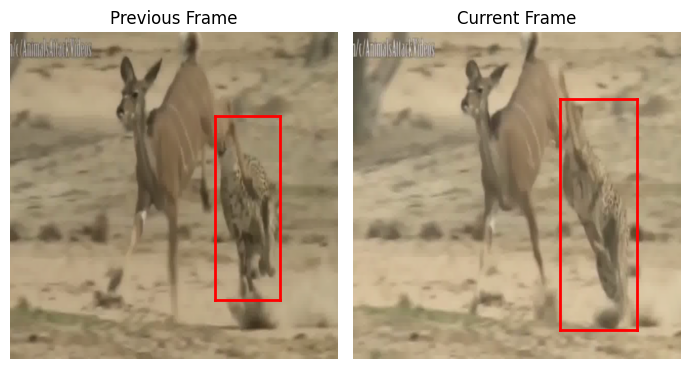

Visualized pair index: 61922


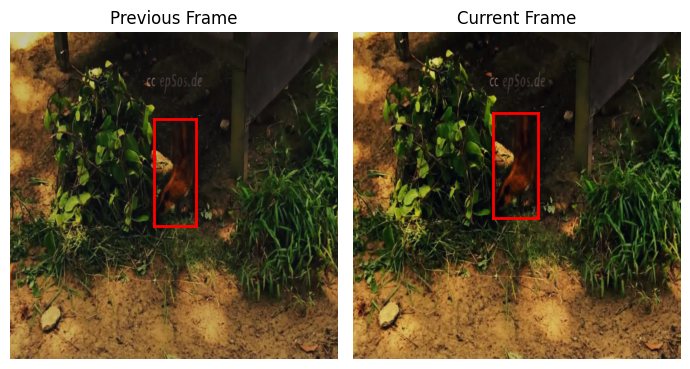

Visualized pair index: 1037361


In [15]:
for _ in range(2):
    selected_idx = visualize_normalized_frame_pair(train_pairset)
    print(f"Visualized pair index: {selected_idx}")

## DataLoader

In [16]:
# Set Batch Size
BATCH_SIZE = 256, 256, 1

In [17]:
# Use Teacher Forcing
train_pairset.use_teacher_forcing = True
valid_pairset.use_teacher_forcing = True

In [18]:
MULTI_PROCESSING = True  # Set False if DataLoader is causing issues

import multiprocessing
from platform import system

cpu_cores = multiprocessing.cpu_count()
num_workers = 12
if MULTI_PROCESSING and system() != "Windows":  # Multiprocess data loading is not supported on Windows
    num_workers += ADDITIONAL_GPU
    print(f"INFO: Number of CPU cores - {num_workers}/{cpu_cores}")
else:
    print("INFO: Using DataLoader without multi-processing.")

train_loader = DataLoader(train_pairset, batch_size=BATCH_SIZE[0], shuffle=True, num_workers=num_workers)
valid_loader = DataLoader(valid_pairset, batch_size=BATCH_SIZE[1], shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_pairset, batch_size=BATCH_SIZE[2], shuffle=False, num_workers=num_workers)

INFO: Number of CPU cores - 13/48


## Define Model
### APT: Adaptive Plugin for TTA (Test-time Adaptation)

In [19]:
yolo_pretrained = YOLOX(head=YOLOXHead(30))
yolo_pretrained.load_state_dict(torch.load("./pretrained/yoloxl_vid.pth", map_location="cpu")['model'])

for param in yolo_pretrained.parameters():
    param.requires_grad = False  # Freeze YOLO

yolo_pretrained

YOLOX(
  (backbone): YOLOPAFPN(
    (backbone): CSPDarknet(
      (stem): Focus(
        (conv): BaseConv(
          (conv): Conv2d(12, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
      )
      (dark2): Sequential(
        (0): BaseConv(
          (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (1): CSPLayer(
          (conv1): BaseConv(
            (conv): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act): SiLU(inplace=True)
          )
          (conv2): BaseConv(
            (conv): Conv2d(128, 64, kernel_si

In [20]:
class FeatureNormalizationLayer(nn.Module):
    def __init__(self, target_dim=256):
        super().__init__()
        self.target_dim = target_dim
        
        # Keep only channel dimension
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Linear compression
        self.linear_compress = nn.AdaptiveAvgPool1d(target_dim)
        
        # Feature normalization
        self.feature_norm = nn.Sequential(
            nn.LayerNorm(target_dim),
            nn.Dropout(0.1)
        )

    def forward(self, x):
        # Apply adaptive pooling
        x = self.adaptive_pool(x)
        
        # Squeeze channel dimension
        x = x.squeeze(-1).squeeze(-1)
        
        # Linear compression
        x = self.linear_compress(x)
        
        # Feature normalization
        x = self.feature_norm(x)
        
        return x

In [21]:
class APT(nn.Module):
    """
    Autoencoder for Adaptation
    which learns how to sniff out the frame changes to predict next bounding boxes.
    """

    def __init__(self, feature_dim=256, bbox_dim=4, hidden_dim=32):
        super().__init__()

        self.feature_dim = feature_dim
        self.bbox_dim = bbox_dim
        self.hidden_dim = hidden_dim

        # Feature normalization layer for encoder-agnostic adaptation
        self.feature_norm = FeatureNormalizationLayer(target_dim=feature_dim)

        # Lightweight feature sniffer
        self.feature_sniffer = nn.Sequential(
            nn.Linear(feature_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 4 * 3)
        )

        # Previous bbox encoder
        self.bbox_encoder = nn.Sequential(
            nn.Linear(bbox_dim, hidden_dim // 4),
            nn.ReLU()
        )

        # Fusion layer
        self.fusion = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )

        # Prediction head
        self.predictor = nn.Sequential(
            nn.Linear(hidden_dim, bbox_dim),
            nn.Sigmoid()  # Normalize bbox coordinates to [0,1]
        )

        # Optional: Sparsity regularization
        self.activation = {}

    def forward(self, features, prev_bbox):
        # Normalize encoder features to be encoder-agnostic
        norm_features = self.feature_norm(features)

        # Extract relevant features from current frame
        sniffed_features = self.feature_sniffer(norm_features)

        # Encode previous bbox information
        bbox_features = self.bbox_encoder(prev_bbox)

        # Fuse features
        fused = self.fusion(
            torch.cat([sniffed_features, bbox_features], dim=-1)
        )

        # Predict next bbox
        next_bbox = self.predictor(fused)

        return next_bbox

In [22]:
class MultiScaleAPT(nn.Module):
    """
    Autoencoder for Adaptation (Multi-Scale Approach)
    which learns how to sniff out the frame changes to predict next bounding boxes.
    """

    def __init__(self, feature_dim=256, scale_dim=[256, 512, 1024], bbox_dim=4, hidden_dim=512):
        super().__init__()

        self.feature_dim = feature_dim
        self.bbox_dim = bbox_dim
        self.hidden_dim = hidden_dim

        # Feature normalization layer for encoder-agnostic adaptation
        self.feature_norms = nn.ModuleList([
            FeatureNormalizationLayer(dim) for dim in scale_dim
        ])

        # Combiner
        self.projections = nn.ModuleList([
            nn.Linear(dim, feature_dim) for dim in scale_dim
        ])

        # Lightweight feature sniffer
        self.feature_sniffer = nn.Sequential(
            nn.Linear(feature_dim * len(scale_dim), hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 4 * 3)
        )

        # Previous bbox encoder
        self.bbox_encoder = nn.Sequential(
            nn.Linear(bbox_dim, hidden_dim // 4),
            nn.ReLU()
        )

        # Fusion layer
        self.fusion = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )

        # Prediction head
        self.predictor = nn.Sequential(
            nn.Linear(hidden_dim, bbox_dim),
            nn.Sigmoid()  # Normalize bbox coordinates to [0,1]
        )

        # Optional: Sparsity regularization
        self.activation = {}

    def forward(self, features, prev_bbox):
        # Normalize encoder features to be encoder-agnostic
        normalized_features = []
        for i, feature in enumerate(features):
            norm_feat = self.feature_norms[i](feature)
            proj_feat = self.projections[i](norm_feat)
            normalized_features.append(proj_feat)

        # Extract relevant features from current frame
        concat_features = torch.cat(normalized_features, dim=1)
        sniffed_features = self.feature_sniffer(concat_features)

        # Encode previous bbox information
        bbox_features = self.bbox_encoder(prev_bbox)

        # Fuse features
        fused = self.fusion(
            torch.cat([sniffed_features, bbox_features], dim=-1)
        )

        # Predict next bbox
        next_bbox = self.predictor(fused)

        return next_bbox

In [23]:
class TestTimeAdaptiveYOLOX(nn.Module):
    def __init__(
        self, encoder: nn.Module, decoder: nn.Module,
        feature_dim=256, bbox_dim=4, hidden_dim=32
    ):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.apt = MultiScaleAPT(
            feature_dim=feature_dim, bbox_dim=bbox_dim,
            hidden_dim=hidden_dim
        )

    def forward(self, current_frame, prev_bbox, use_teacher_forcing=False):
        # Extract features using YOLO encoder
        features = self.encoder(current_frame)

        # Adapt using APT
        pred_bbox = self.apt(features, prev_bbox)

        if use_teacher_forcing:
            output = None
        else:
            # Use YOLO decoder for final prediction
            output = self.decoder(features)

        return output, pred_bbox

In [24]:
# Initialize Model
model = TestTimeAdaptiveYOLOX(
    encoder=yolo_pretrained.backbone, decoder=yolo_pretrained.head,
    feature_dim=256, bbox_dim=4, hidden_dim=512
)

if ADDITIONAL_GPU:
    model = nn.DataParallel(model, device_ids=list(range(DEVICE_NUM, DEVICE_NUM+ADDITIONAL_GPU+1)))
model.to(device)

DataParallel(
  (module): TestTimeAdaptiveYOLOX(
    (encoder): YOLOPAFPN(
      (backbone): CSPDarknet(
        (stem): Focus(
          (conv): BaseConv(
            (conv): Conv2d(12, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act): SiLU(inplace=True)
          )
        )
        (dark2): Sequential(
          (0): BaseConv(
            (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
            (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act): SiLU(inplace=True)
          )
          (1): CSPLayer(
            (conv1): BaseConv(
              (conv): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (act): SiLU(inplace=True)
     

## Training

In [34]:
def cxcywh_to_xyxy(boxes):
    """Convert bbox coordinates from (cx, cy, w, h) to (x1, y1, x2, y2)"""
    cx, cy, w, h = boxes.unbind(-1)
    x1 = cx - 0.5 * w
    y1 = cy - 0.5 * h
    x2 = cx + 0.5 * w
    y2 = cy + 0.5 * h
    return torch.stack((x1, y1, x2, y2), dim=-1)

In [35]:
def compute_confidence_from_iou(pred_boxes, gt_boxes):
    """Compute confidence scores using IoU values"""
    iou_matrix = box_iou(pred_boxes, gt_boxes)  # Compute IoU
    confidence_scores, _ = torch.max(iou_matrix, dim=1)  # Use max IoU as confidence
    return confidence_scores

In [38]:
def m_ap(gt_boxes, pred_boxes, pred_scores=None, iou_threshold=0.5):
    """Compute Average Precision (AP) using PyTorch"""
    # Compute IoU matrix
    iou_matrix = box_iou(pred_boxes, gt_boxes)

    # Sort predicted boxes by confidence scores (descending order)
    if not pred_scores:
        pred_scores = compute_confidence_from_iou(pred_boxes, gt_boxes)
    sorted_indices = torch.argsort(-pred_scores)
    pred_boxes = pred_boxes[sorted_indices]
    pred_scores = pred_scores[sorted_indices]
    iou_matrix = iou_matrix[sorted_indices]

    # Determine True Positives (TP) and False Positives (FP)
    tp = torch.zeros(len(pred_boxes))
    fp = torch.zeros(len(pred_boxes))
    matched_gt = torch.zeros(len(gt_boxes))  # Track matched ground truth boxes

    for i, ious in enumerate(iou_matrix):
        best_iou, best_gt_idx = torch.max(ious, dim=0)
        if best_iou >= iou_threshold and matched_gt[best_gt_idx] == 0:
            tp[i] = 1  # True Positive
            matched_gt[best_gt_idx] = 1  # Mark ground truth as matched
        else:
            fp[i] = 1  # False Positive

    # Compute Precision-Recall curve
    tp_cumsum = torch.cumsum(tp, dim=0)
    fp_cumsum = torch.cumsum(fp, dim=0)
    recall = tp_cumsum / len(gt_boxes)
    precision = tp_cumsum / (tp_cumsum + fp_cumsum + 1e-6)

    # Compute AP (area under Precision-Recall curve)
    ap = torch.trapz(precision, recall)  # Trapezoidal Rule
    return ap

### Default Pre-training Process
Using Teacher forcing

In [39]:
# Set Epoch Count & Learning Rate
EPOCHS = 10
LEARNING_RATE = 1e-4, 1e-6
WEIGHT_DECAY = 0.05
MSE_WEIGHT = 0.05
CIoU_WEIGHT = 0.95

criterion = nn.MSELoss()
wandb.watch(model, criterion, log="all", log_freq=10)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE[0], weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=LEARNING_RATE[1])

In [ ]:
model_id = "apt_model"
if not path.isdir(path.join(".", "models")) or not path.isdir(path.join(".", "models", model_id)):
    os.mkdir(path.join(".", "models"))
    os.mkdir(path.join(".", "models", model_id))

train_length, valid_length = map(len, (train_loader, valid_loader))
epochs = tqdm(range(EPOCHS), desc="Running Epochs")
with (tqdm(total=train_length, desc="Training") as train_progress,
        tqdm(total=valid_length, desc="Validation") as valid_progress):  # Set up Progress Bars
    best_ciou = float("inf")

    for epoch in epochs:
        train_progress.reset(total=train_length)
        valid_progress.reset(total=valid_length)

        train_loss, train_ciou, train_map = 0, 0, 0

        # Training
        model.train()
        for i, (curr_frame, prev_bbox, curr_bbox) in enumerate(train_loader):
            optimizer.zero_grad()

            prev_bbox, curr_bbox = prev_bbox.to(device), curr_bbox.to(device)
            _, pred_bbox = model(curr_frame.to(device), prev_bbox, use_teacher_forcing=True)  # Use Teacher Forcing while training

            pred_boxes_list = [pred_bbox[i].unsqueeze(0) for i in range(len(pred_bbox))]
            target_boxes_list = [curr_bbox[i].unsqueeze(0) for i in range(len(curr_bbox))]

            mse_loss = criterion(pred_bbox, curr_bbox)
            ciou_values = complete_box_iou(cxcywh_to_xyxy(pred_bbox), cxcywh_to_xyxy(curr_bbox))
            ciou_loss = 1 - torch.diag(ciou_values).mean()

            (MSE_WEIGHT*mse_loss/BATCH_SIZE[0] + CIoU_WEIGHT*ciou_loss).backward()
            optimizer.step()
            scheduler.step()

            train_loss += (mse_loss/BATCH_SIZE[0]).item() / train_length
            train_ciou += ciou_loss / train_length
            map_score = m_ap(cxcywh_to_xyxy(pred_bbox), cxcywh_to_xyxy(curr_bbox))
            train_map += map_score / train_length

            train_progress.update(1)
            if i != train_length-1: wandb.log({'MSE Loss': mse_loss.item()/BATCH_SIZE[0], 'CIoU Loss': ciou_loss, 'mAP': map_score})
            print(f"\rEpoch [{epoch+1:2}/{EPOCHS}], Step [{i+1:4}/{train_length}], MSE Loss: {mse_loss.item()/BATCH_SIZE[0]:.6%}, CIoU Loss: {ciou_loss:.6f}, mAP: {map_score:.2%}", end="")

        print(f"\rEpoch [{epoch+1:2}/{EPOCHS}], Step [{train_length}/{train_length}], MSE Loss: {train_loss:.6%}, CIoU Loss: {train_ciou:.6f}, mAP: {train_map:.2%}", end="")
        val_loss, val_ciou, valid_map = 0, 0, 0

        # Validation
        model.eval()
        with torch.no_grad():
            for curr_frame, prev_bbox, curr_bbox in valid_loader:
                prev_bbox, curr_bbox = prev_bbox.to(device), curr_bbox.to(device)
                _, pred_bbox = model(curr_frame.to(device), prev_bbox, use_teacher_forcing=True)  # Use Teacher Forcing while training

                val_loss += criterion(pred_bbox, curr_bbox).item() / BATCH_SIZE[0] / valid_length
                ciou_values = complete_box_iou(cxcywh_to_xyxy(pred_bbox), cxcywh_to_xyxy(curr_bbox))
                val_ciou += (1-torch.diag(ciou_values).mean()) / valid_length
                valid_progress.update(1)

        wandb.log({'Train MSE Loss': train_loss, 'Train CIoU Loss': train_ciou, 'Train mAP': train_map, 'Val MSE Loss': val_loss, 'Val CIoU Loss': val_ciou, 'Val mAP': valid_map})
        print(f"\rEpoch [{epoch+1:2}/{EPOCHS}], Step [{train_length}/{train_length}], MSE Loss: {train_loss:.6f}, CIoU Loss: {train_ciou:.6f}, mAP: {train_map:.2%}, Valid MSE Loss: {val_loss:.6f}, Valid CIoU Loss: {val_ciou:.6f}, Valid mAP: {valid_map:.2%}", end="\n" if (epoch+1) % 1 == 0 or (epoch+1) == EPOCHS else "")

        # Model Save
        target = model.module if ADDITIONAL_GPU else model
        save_path = path.join(".", "models", model_id, f"epoch{epoch}_{val_ciou:.6f}.pt")
        torch.save(target.apt.state_dict(), save_path)
        torch.save(target.state_dict(), save_path.replace(".pt", ".full.pt"))
        if best_ciou > val_ciou:
            best_ciou = val_ciou
            torch.save(target.apt.state_dict(), path.join(".", "models", model_id, f"best.pt"))

Running Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/4895 [00:00<?, ?it/s]

Validation:   0%|          | 0/551 [00:00<?, ?it/s]

Epoch [ 1/10], Step [ 533/4895], MSE Loss: 0.000033%, CIoU Loss: 0.057584, mAP: 0.98

## Test

### Test Dataset

In [ ]:
class TestVideoDataset(Dataset):
    def __init__(self, base_dataset: GOT10kDataset):
        super().__init__()
        self.base_dataset = base_dataset
        self.sequences = self._organize_sequences()
        
    def _organize_sequences(self):
        # Group images by sequence
        sequences = defaultdict(list)
        for idx, (img_path, _) in enumerate(self.base_dataset.samples):
            seq_name = path.dirname(img_path)
            sequences[seq_name].append((idx, img_path))
            
        # Sort frames in each sequence
        organized_sequences = []
        for seq_name, frames in sequences.items():
            # Sort frames by filename
            frames.sort(key=lambda x: x[1])
            
            # Get ground truth data
            gt_path = path.join(seq_name, 'groundtruth.txt')
            if path.exists(gt_path):
                groundtruth = np.loadtxt(gt_path, delimiter=',')
                
                # Get original image dimensions for normalization
                with Image.open(frames[0][1]) as img:
                    orig_w, orig_h = img.size
                
                # Normalize ground truth coordinates
                normalized_gt = groundtruth.copy()
                normalized_gt[:, 0] /= orig_w  # x_min
                normalized_gt[:, 1] /= orig_h  # y_min
                normalized_gt[:, 2] /= orig_w  # width
                normalized_gt[:, 3] /= orig_h  # height
                
                organized_sequences.append({
                    'frame_indices': [f[0] for f in frames],
                    'groundtruth': normalized_gt
                })
        
        return organized_sequences
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        
        # Stack frames into a 4D tensor [frames, channels, height, width]
        frames = []
        for frame_idx in sequence['frame_indices']:
            img, _ = self.base_dataset[frame_idx]
            frames.append(img.unsqueeze(0))  # Add frame dimension
        
        frames_tensor = torch.cat(frames, dim=0)
        groundtruth = torch.FloatTensor(sequence['groundtruth'])
        
        return frames_tensor, groundtruth

In [ ]:
test_video_dataset = TestVideoDataset(base_dataset=valid_dataset)
test_video_loader = DataLoader(test_video_dataset, batch_size=1, shuffle=False, num_workers=cpu_cores)

### Baseline - Normal YOLO

In [ ]:
model = YOLO("./pretrained/yolo11m.pt")
model.to(device)

In [ ]:
test_length = len(test_video_loader)

model.eval()
for frames, groundtruth in tqdm(test_video_loader, desc="Testing Baseline..."):
    frames, groundtruth = frames.to(device), groundtruth.to(device)
    
    with torch.no_grad():
        output = model(frames)
    
    # Visualize output
    output = output.cpu().numpy()
    for j in range(len(output)):
        visualize_normalized_frame_pair(test_video_dataset, idx=i, figsize=(10, 5))
        print(f"Predicted Bounding Box: {output[j]}")
        print(f"Ground Truth Bounding Box: {groundtruth[j].cpu().numpy()}")

In [ ]:
test_length = len(test_video_loader)

model.eval()
for prev_frame, curr_frame, prev_bbox, curr_bbox in tqdm(test_loader):
    prev_bbox, curr_bbox = prev_bbox.to(device), curr_bbox.to(device)
    _, pred_bbox, sparsity_loss = model(curr_frame.to(device), prev_bbox)

    val_loss += criterion(pred_bbox, curr_bbox).item() / valid_length
    val_ciou += (1-avg([calculate_ciou(pred_bbox[j].detach().cpu().numpy(), curr_bbox[j].cpu().numpy()) for j in range(len(pred_bbox))])) / valid_length
    valid_progress.update(1)

In [ ]:
# Load Model
model_id = "apt_model.full"

model.load_state_dict(torch.load(path.join(".", "models", f"{model_id}.pt")))
model.to(device)

In [ ]:
test_length = len(test_loader)


model.eval()
with torch.no_grad():
    for curr_frame, prev_bbox, curr_bbox in valid_loader:
        prev_bbox, curr_bbox = prev_bbox.to(device), curr_bbox.to(device)
        _, pred_bbox, sparsity_loss = model(curr_frame.to(device), prev_bbox, use_teacher_forcing=True)  # Use Teacher Forcing while training

        val_loss += criterion(pred_bbox, curr_bbox).item() / valid_length
        val_ciou += (1-avg([calculate_ciou(pred_bbox[j].detach().cpu().numpy(), curr_bbox[j].cpu().numpy()) for j in range(len(pred_bbox))])) / valid_length
        valid_progress.update(1)

model.eval()
with torch.no_grad():
    for inputs, targets in tqdm(test_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        corrects += (preds == targets.data).sum()
        print(f"Model Accuracy: {corrects/test_length:%}", end="\r")